In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import urllib.request, json , time, os, difflib, itertools
import statsmodels.formula.api as smf
import intrinio_sdk #https://github.com/intrinio/python-sdk for the full list of
# requires API key

In [5]:
query_url_1= "https://query2.finance.yahoo.com/v10/finance/quoteSummary/"+"BC8.DE"+"?modules=assetProfile"

with urllib.request.urlopen(query_url_1) as url:
            parsed_1 = json.loads(url.read().decode())

parsed_1["quoteSummary"]["result"][0]['assetProfile']["longBusinessSummary"]
#parsed_1["quoteSummary"]["result"][0]['assetProfile']["fullTimeEmployees"]


'Bechtle AG provides information technology services primarily in Europe. The company operates in two segments, IT System House & Managed Services, and IT E-Commerce. The IT System House & Managed Services segment offers IT strategy consulting, hardware and software selling, project planning and implementation, system integration, IT services, and training for IT operation. It provides applications for business intelligence, customer relationship management, enterprise resource planning, product life-cycle management, computer-aided design/computer-aided manufacturing, product data management, enterprise content management, document management systems, artificial intelligence, and collaboration; and modern workplace solutions. This segment also offers data center, networking, security, consulting, managed, professional, financial, and remarketing services. The IT E-Commerce segment provides hardware and software products, and peripherals with a multi-brand portfolio that comprises appr

# Goals and Purpose
## EPP
-Package for FF 3/5 Factors
-possibility to load data / test other factors
-build portfolio based on factors
-simple backtest ### MASTER
-same, but "special" ### BUSINESS
-building upon EPP package
-construct special multifacor portfolios for germany / europe
-"automatic" monthly rebalancing according to the metrics
-set up thoose portfolios on wikifolio ### more ideas
-data collection (weekly datacrawler to collect stockprice info for selected stocks to be independent of databases.
- Store this data on AWS / external drive)

Updating the env to use scraping:

`conda activate myenv`


`conda env update --file local.yml --prune`

In [5]:
# Some stuff to play arroudn for now

def realized_volatility(x):
    return np.sqrt(np.sum(x**2))
    
def get_data_d(TICKR):
    df_yahoo = yf.download(TICKR,
    start='2000-01-01',
    end='2021-12-31',
    progress=False)
    df = df_yahoo.loc[:, ['Adj Close']]
    df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
    df['simple_rtn'] = df.adj_close.pct_change()
    df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
    return df

def get_data_m(TICKR):
    df_yahoo = yf.download(TICKR,
    start='2000-01-01',
    end='2020-12-31',
    progress=False)
    df = df_yahoo.loc[:, ['Adj Close']]
    df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
    pd.to_datetime(df.index)
    df_mm = df.resample('1M').mean()
    df_mm['simple_rtn'] = df.adj_close.pct_change()
    df_mm['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
    return df_mm

def indentify_outliers(row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

def plot_stock(df):
    fig, ax = plt.subplots(3, 1, figsize=(24, 20))#sharex=True)
    ax[0].plot(df.adj_close)
    ax[0].set(xlabel = 'Date',title = 'MSFT time series', ylabel = 'Stock price ($)')
    ax[1].plot(df.simple_rtn, linestyle='solid')
    ax[1].set(xlabel = 'Date', ylabel = 'Simple returns (%)')
    ax[2].plot(df.log_rtn)
    ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')

In [6]:
df = get_data_d("DDOG")
df["rv"] = df.log_rtn.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df.index
#df

DatetimeIndex(['2019-09-19', '2019-09-20', '2019-09-23', '2019-09-24',
               '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-30',
               '2019-10-01', '2019-10-02',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=576, freq=None)

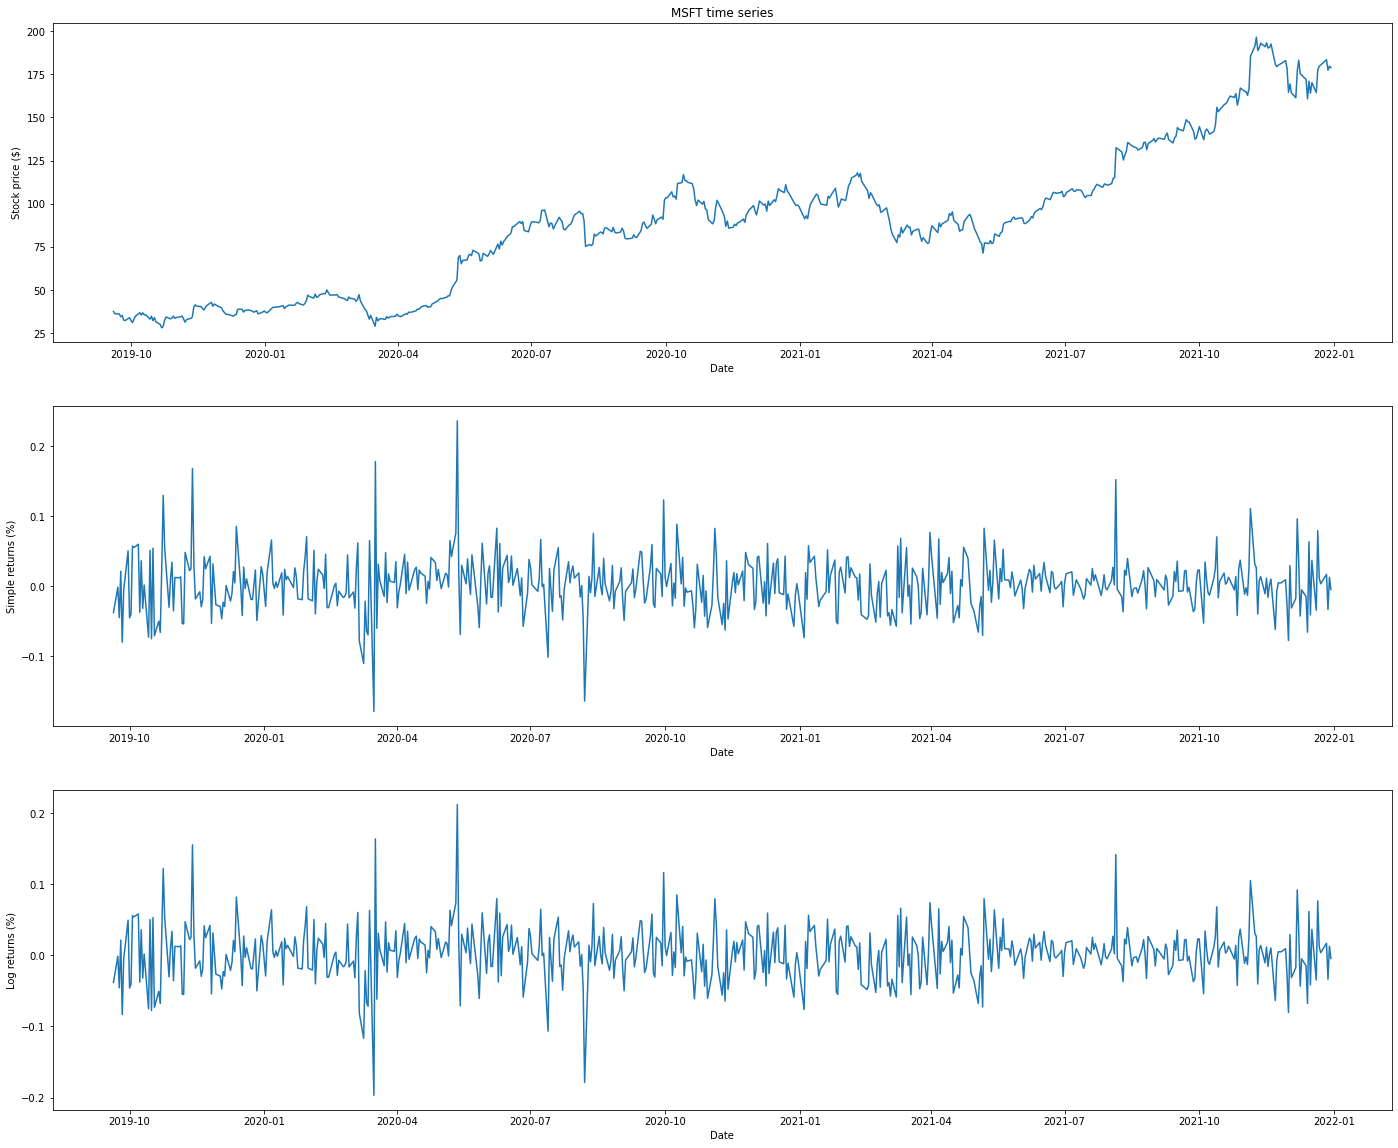

In [7]:
plot_stock(get_data_d("DDOG"))

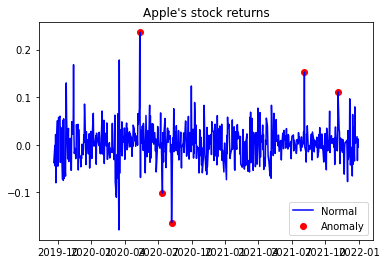

In [8]:
df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()
#df_rolling

# join df´s
df_outliers = df.join(df_rolling)
df_outliers
# identify outliers and extract their values
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]


fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn,
 color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn,
 color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')

,adj_close,simple_rtn,log_rtn
Date,,,
1999-12-31,1469.250000,NaN,NaN
2000-01-03,1455.219971,-0.009549,-0.009595
2000-01-04,1399.420044,-0.038345,-0.039099
2000-01-05,1402.109985,0.001922,0.001920
2000-01-06,1403.449951,0.000956,0.000955
...,...,...,...
2021-12-23,4725.790039,0.006224,0.006204
2021-12-27,4791.189941,0.013839,0.013744
2021-12-28,4786.350098,-0.001010,-0.001011


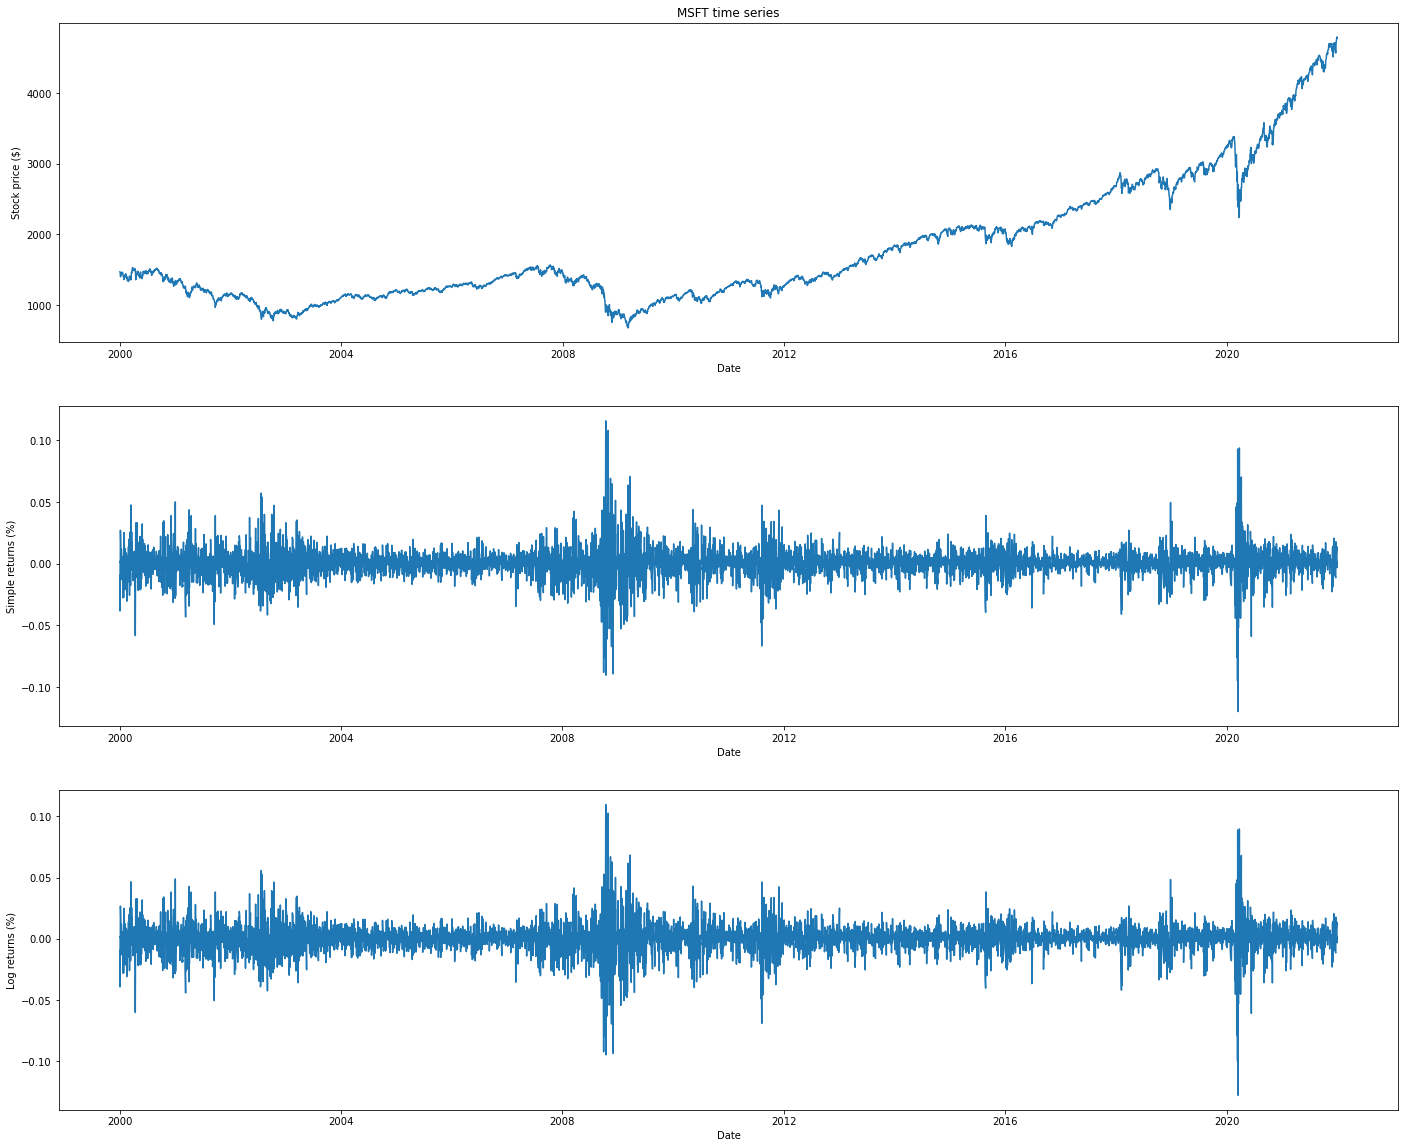

In [9]:
SP500_frame = get_data_d("^GSPC")
plot_stock(SP500_frame)
SP500_frame

## CAPM

In [10]:
RISKY_ASSET = 'AAPL'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2018-01-01'
END_DATE = '2020-12-31'


df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
     start=START_DATE,
     end=END_DATE,
     adjusted=True,
     progress=False)
df
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset',
    MARKET_BENCHMARK: 'market'}) \
    .resample('M') \
    .last().pct_change().dropna()  #before: .last()

X

 # rf
N_DAYS = 90
df_rf = yf.download('^IRX', start=START_DATE, end=END_DATE)
rf = df_rf.resample('M').last().Close / 100
rf = ( 1 / (1 - rf * (N_DAYS / 360)) )**(1 / N_DAYS)
rf = (rf ** 30) - 1

X["asset_rf"] = X.asset - rf
X["market_rf"] = X.market -rf

covariance = X.cov().iloc[2,3]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

[*********************100%***********************]  1 of 1 completed


1.3100309670402521

In [11]:
#y = X.pop('asset')
#X = sm.add_constant(X)
regressor = sm.add_constant(X[["market_rf"]])
capm_model = sm.OLS(X.asset_rf, regressor).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:               asset_rf   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     34.23
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           1.50e-06
Time:                        14:49:28   Log-Likelihood:                 44.018
No. Observations:                  35   AIC:                            -84.04
Df Residuals:                      33   BIC:                            -80.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0277      0.012      2.284      0.0

In [4]:
#RISKY_ASSET = 'AAPL'
START_DATE = '2019-01-01'
END_DATE = '2020-12-31'


########### Load the data from the source CSV file and keep only the monthly data:

# factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)
# STR_TO_MATCH = ' Annual Factors: January-December '
# indices = factor_df.iloc[:, 0] == STR_TO_MATCH
# start_of_annual = factor_df[indices].index[0]
# factor_df = factor_df[factor_df.index < start_of_annual] # delete all other than the monthly data
# factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']
# factor_df['date'] = pd.to_datetime(factor_df['date'], format='%Y%m').dt.strftime("%Y-%m")
# factor_df = factor_df.set_index('date')
# factor_df = factor_df.loc[START_DATE:END_DATE]

############# automaticall download csv, read, and delete
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
import pandas as pd
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end = END_DATE) # default is monthly  #ff_dict.keys()  #print(ff_dict["DESCR"])
factor_df = ff_dict[0]#monthly factors. 1 for annual
factor_df.rename(columns = {"Mkt-RF": "mkt_rf", "SMB":"smb", "HML":"hml", "RF":"rf"}, inplace= True) 
factor_df["mkt"] = factor_df.mkt_rf + factor_df.rf
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)
factor_df.columns

Index(['mkt_rf', 'smb', 'hml', 'rf', 'mkt'], dtype='object')

In [2]:
# for european stocks
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
import pandas as pd

START_DATE = '2000-05-01'
END_DATE = '2022-01-22'

ff_dict = web.DataReader('Europe_5_Factors', 'famafrench', start=START_DATE, end = END_DATE) # default is monthly  #ff_dict.keys()  #print(ff_dict["DESCR"])
factor_df = ff_dict[0]#monthly factors. 1 for annual
factor_df.rename(columns = {"Mkt-RF": "mkt_rf", "SMB":"smb", "HML":"hml", "RMW":"rmw", "CMA":"cma", "RF":"rf"}, inplace= True) 
factor_df["mkt"] = factor_df.mkt_rf + factor_df.rf
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)
meandf = factor_df[["smb", "hml", "rmw", "cma"]].mean()*100
meandf.values

array([0.2525    , 0.32238462, 0.32992308, 0.19480769])

In [18]:
# Risky Assets Download
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'

ff_data = factor_df.copy(1)
ff_data["ra_rtn"] = y.values
ff_data['excess_rtn'] = ff_data.ra_rtn - ff_data.rf
ff_data

ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()
print(ff_model.summary())

[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.749
Date:                Wed, 09 Feb 2022   Prob (F-statistic):              0.157
Time:                        22:23:05   Log-Likelihood:                 201.94
No. Observations:                 260   AIC:                            -395.9
Df Residuals:                     256   BIC:                            -381.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

## FF Portfolio

tbd